['bonus', 0.23081215379602504]
['expenses', 0.17093825628771855]
['total_payments', 0.16459235209235207]
['restricted_stock', 0.12029998258446517]
['from_messages', 0.07604166666666666]
['total_stock_value', 0.058568294200478217]
['from_poi_to_this_person', 0.055447048611111091]
['salary', 0.054315476190476192]
['exercised_stock_options', 0.031684027777777769]
['other', 0.029966476103628719]
['from_this_person_to_poi', 0.0073342656893005198]


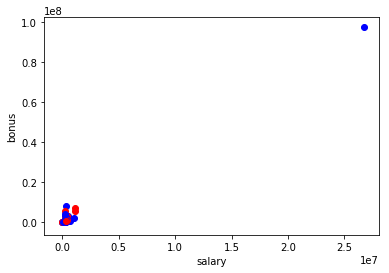

None


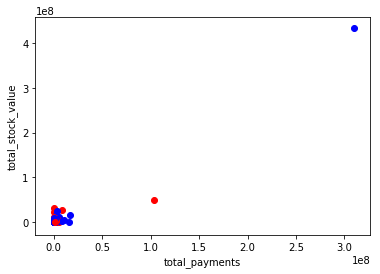

None


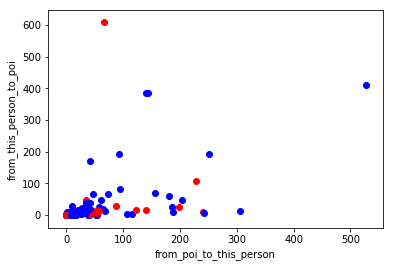

None


In [97]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from numpy import mean
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary'] # You will need to use more features
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

first_feature = 'poi'
email_features = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
financial_features = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]


#Decision tree using features with non-null importance
clf = DecisionTreeClassifier(random_state = 75)
clf.fit(df.ix[:,1:], df.ix[:,:1])

# show the features with non null importance, sorted and create features_list of features for the model
features_importance = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        features_importance.append([df.columns[i+1], clf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
for f_i in features_importance:
    print f_i
features_list = [x[0] for x in features_importance]
features_list.insert(0, 'poi')

features_list = [first_feature] + financial_features + email_features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict
def LetsPlotOutlier(data_dict, feature_x, feature_y):
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

print(LetsPlotOutlier(data_dict, 'salary', 'bonus'))   
print(LetsPlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(LetsPlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))


#task 3
def fraction_func(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI""" 
    fraction= 0
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return fraction
    fraction = poi_messages / all_messages
    return fraction

for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = fraction_func(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = fraction_func(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi

#  create new copies of feature list 
my_feature_list = features_list+['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                                 'shared_receipt_with_poi', 'fraction_to_poi', 'fraction_from_poi']


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


In [87]:
number_of_data_points = len(data_dict)
print ("number_of_data_points {}".format(number_of_data_points))

number_of_data_points 146


In [88]:
import numpy as np
import pandas as pd
df = pd.DataFrame.from_dict(data_dict, orient = 'index')

#Order columns in DataFrame, exclude email column
#inspired by tukey method
df = df[features_list]
df = df.replace('NaN', 0)
outliers = df.quantile(.5) + 1.5 * (df.quantile(.75)-df.quantile(.25))
pd.DataFrame((df[1:] > outliers[1:]).sum(axis = 1), columns = ['# of outliers']).\
    sort_values('# of outliers',  ascending = [0]).head(7)

,# of outliers
FREVERT MARK A,13
LAY KENNETH L,13
SKILLING JEFFREY K,12
WHALLEY LAWRENCE G,12
TOTAL,12
LAVORATO JOHN J,10
HAEDICKE MARK E,8


In [89]:
del data_dict["TOTAL"]
data_dict.pop( 'TOTAL', 0 )

#remove Outliers

def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'LAVORATO JOHN J']
remove_outlier(data_dict, outliers)

In [90]:
df.ix[:,:15] = df.ix[:,:15].fillna(0)

In [95]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

###4.1  Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

l_clf = LogisticRegression(tol = 0.001, C = 10**-8, penalty = 'l2', random_state = 42)



###4.2  K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)


###4.3 Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

###4.4 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
train_test_split(features, labels, test_size=0.33, random_state=42)

In [92]:
#l2_clf = LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
#max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0)

In [96]:
###evaluate function
### Evaluate all functions
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.33):
    print clf
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            cross_validation.train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print "done.\n"
    print "precision: {}".format(mean(precision))
    print "recall:    {}".format(mean(recall))
    return mean(precision), mean(recall)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)
#evaluate_clf(l2_clf, features, labels)
### Select Logistic Regression as final algorithm
clf = l_clf


# dump your classifier, dataset and features_list so
# anyone can run/check your results

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

pickle.dump(clf, open("./my_classifier.pkl", "w"))
pickle.dump(my_dataset, open("./my_dataset.pkl", "w"))
pickle.dump(my_feature_list, open("./my_feature_list.pkl", "w"))


dump_classifier_and_data(clf, my_dataset, features_list)

LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

Processing....................................................................................................done.

precision: 0.160321668446
recall:    0.178241666667
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.001, verbose=0)

Processing....................................................................................................done.

precision: 0.0599222343987
recall:    0.0589157647908
SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.00